## This part is used to process and normalize ABI L1 data

In [1]:
## Prepare the package we need
import h5py as h5
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Read geo-information(resolution is 1 km)
geo_path = '/Users/yihan/Documents/Project/Cloud_Aerosol_Project/ABI_sample_data/'
geo_file = geo_path + 'goesr_16_static_1km.h5'   # goes static data 
f_geo = h5.File(geo_file, 'r')
       
### Show the groups in the geo_file
print(f_geo.keys())
   
lat = f_geo['Latitude'][:]
lon = f_geo['Longitude'][:]

f_geo.close()     # Do not forget to close the file

<KeysViewHDF5 ['Latitude', 'Longitude', 'SpaceMask', 'VAA', 'VZA']>


In [3]:
## Read ABI L1 data
data_path = '/Users/yihan/Documents/Project/Cloud_Aerosol_Project/ABI_sample_data/'
dataSetName = data_path + 'OR_ABI-L1b-RadF-M6C01_G16_s20203081050179_e20203081059486_c20203081059543.nc'

channel = 1    # the channel you want to read, it should match the nc file!!!
dataSet = nc.Dataset(dataSetName, 'r')    

#print(dataSet.__dict__)
#print(dataSet.variables.keys())

Rad = dataSet['Rad'][:]
fill_value = dataSet.variables['Rad']._FillValue       # read invalid data    
Rad[Rad == fill_value] = np.nan     # mask the invalid value

In [4]:
def changeResolution(dataSet, variable):

    fill_value = dataSet.variables[variable]._FillValue       # read invalid data    

    if 'x' not in dataSet.dimensions:
        print("missing x dimension")
        return
        
    if 'y' not in dataSet.dimensions:
        print("missing y dimension")
        return

    xDim = dataSet.dimensions['x'].size
    yDim = dataSet.dimensions['y'].size
    
    if 'spatial_resolution' not in dataSet.__dict__:
        print("missing spatial resolution param")
        return

    resolution = dataSet.__dict__["spatial_resolution"]
    
    
    if("1km" in resolution):
        # In this case, we do not need to change resolution
        # just return the original one
        grid = np.zeros([yDim, xDim])
        grid[:,:] = dataSet[variable][:]
        grid[grid == fill_value] = np.nan 
        
        return grid
    
    elif("0.5km" in resolution):
        newX = int(xDim / 2)
        newY = int(yDim / 2)
        
        grid = np.zeros([yDim, xDim])
        grid[:,:] = dataSet[variable][:]
        grid[grid == fill_value] = np.nan 
    
        newGrid = np.zeros([newY, newX])
        
        for y in range(0, newY):
            for x in range(0, newX):
                newGrid[y, x] = grid[y * 2, x * 2]
                
        return newGrid
        
    elif("2km" in resolution):
        newX = int(xDim * 2)
        newY = int(yDim * 2)
        
        grid = np.zeros([yDim, xDim])
        grid[:,:] = dataSet[variable][:]
        grid[grid == fill_value] = np.nan 
        
        newGrid = np.zeros([newY, newX])

        for y in range(0, yDim):
            for x in range(0, xDim):
                happyX = x * 2
                happyY = y * 2
                newGrid[happyY, happyX] = grid[y, x]
                newGrid[happyY + 1, happyX] = grid[y, x]
                newGrid[happyY, happyX + 1] = grid[y, x]
                newGrid[happyY + 1, happyX + 1] = grid[y, x]
                
        return newGrid
    else:
        print("unsupported resolution, write some more code dude")
        return
    
### Do you want to normalize resolution into 1km?

def NormResolution(dataSet, variable, your_choice):
    
    if (your_choice):
        resolution = dataSet.__dict__["spatial_resolution"]  
        Rad = changeResolution(dataSet, variable)   
        
    else:
        Rad = dataSet[variable][:]
        fill_value = dataSet.variables[variable]._FillValue       # read invalid data    
        Rad[Rad == fill_value] = np.nan     # mask the invalid value
            
    return Rad

In [5]:
Rad = NormResolution(dataSet, 'Rad', True) # If you want to normalize resolution or not (True or False) 

data = np.ma.zeros(np.shape(Rad))    # dataset used to save L1 data

## read the visible data of channel 1-6
if(channel<7):             
    data = Rad * dataSet['kappa0'][:]
        
## read the infrared wavelength of channel 7-16    
else:
    fk1 = dataSet['planck_fk1'][:]
    fk2 = dataSet['planck_fk2'][:]
    bc1 = dataSet['planck_bc1'][:]
    bc2 = dataSet['planck_bc2'][:]

    data = (fk2/(np.log((fk1/Rad) + 1)) - bc1)/bc2   

## This part gives some simple visualization examples of ABI L1 data

### a. The global image of ABI L1 data

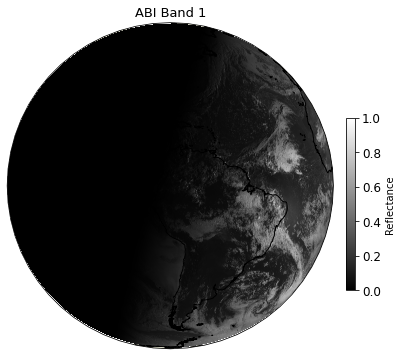

In [6]:
# import the packages we need
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt

# Read the parameters we need from datasets
proj_var = dataSet.variables['goes_imager_projection']

sat_height = proj_var.perspective_point_height
central_lon = proj_var.longitude_of_projection_origin
semi_major = proj_var.semi_major_axis
semi_minor = proj_var.semi_minor_axis

X = dataSet.variables['x'][:] * sat_height
Y = dataSet.variables['y'][:] * sat_height


# plot the figure
fig = plt.figure(figsize = (6, 6))

globe = cartopy.crs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
projection = cartopy.crs.Geostationary(central_longitude=central_lon,satellite_height=sat_height, globe=globe)

ax = fig.add_subplot(1,1,1, projection = projection)


c = ax.imshow(data, origin='upper', extent=(X.min(), X.max(), Y.min(), Y.max()), 
                            transform=projection, cmap = 'gray', vmin = 0.0, vmax = 1.0)

ax.add_feature(cartopy.feature.LAND)     # add land feature
ax.set_global()
ax.coastlines(resolution='50m', color='black', linewidth=1)

# colorbar
cbar_ax = plt.axes([0.92, 0.26, 0.02, 0.4])
bar = plt.colorbar(c, cax=cbar_ax, orientation='vertical')
levs = np.arange(0, 1.01 ,0.2)    #色标范围与取值
bar.ax.tick_params(labelsize = 12)
bar.set_ticks(levs)
bar.set_label('Reflectance')


ax.set_title('ABI Band '+ str(channel), fontsize = 13)
plt.show()

#plt.savefig('ABI_01.png')
dataSet.close()  # Do not forget to close the file after introducing data

### b. The global RGB image of ABI L1 data

In [7]:
# Read ABI L1B file
data_path = '/Users/yihan/Documents/Project/Cloud_Aerosol_Project/ABI_sample_data/'
f_B = data_path + 'OR_ABI-L1b-RadF-M6C01_G16_s20203081050179_e20203081059486_c20203081059543.nc'
f_R = data_path + 'OR_ABI-L1b-RadF-M6C02_G16_s20203081050179_e20203081059487_c20203081059532.nc'
f_G = data_path + 'OR_ABI-L1b-RadF-M6C03_G16_s20203081050179_e20203081059487_c20203081059550.nc'

# blue band (channel 01)
Data_B = nc.Dataset(f_B,'r')
Rad_B = NormResolution(Data_B, 'Rad', True)
Ref_B = Rad_B * Data_B['kappa0'][:]


# red band (channel 02)
Data_R = nc.Dataset(f_R,'r')
Rad_R = NormResolution(Data_R, 'Rad', True)
Ref_R = Rad_R * Data_R['kappa0'][:]


# fake green band (channel 03)
Data_G = nc.Dataset(f_G,'r')
Rad_G = NormResolution(Data_G, 'Rad', True)
Ref_G = Rad_G * Data_G['kappa0'][:]


# projection information
proj_var = Data_B.variables['goes_imager_projection']

sat_height = proj_var.perspective_point_height
central_lon = proj_var.longitude_of_projection_origin
semi_major = proj_var.semi_major_axis
semi_minor = proj_var.semi_minor_axis

X = Data_B.variables['x'][:] * sat_height
Y = Data_B.variables['y'][:] * sat_height

Data_B.close()
Data_R.close()
Data_G.close()

In [8]:
# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(Ref_R, 0, 1)
G = np.clip(Ref_G, 0, 1)
B = np.clip(Ref_B, 0, 1)

# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)  # apply limits again, just in case.

# The RGB array with the raw veggie band
RGB_veggie = np.dstack([R, G, B])

# The RGB array for the true color image
RGB = np.dstack([R, G_true, B])

(-5434182.0342756845,
 5434182.0342756845,
 -5434182.034275684,
 5434182.034275684)

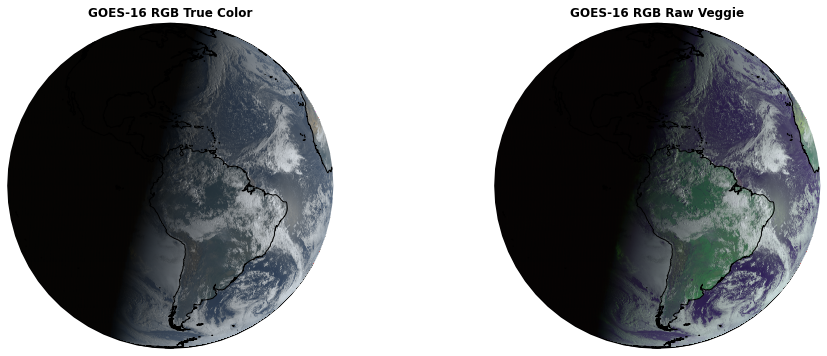

In [9]:
# Plot Figures
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 6))

globe = cartopy.crs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
projection = cartopy.crs.Geostationary(central_longitude=central_lon,satellite_height=sat_height, globe=globe)

ax1 = fig.add_subplot(1,2,1, projection = projection)
ax2 = fig.add_subplot(1,2,2, projection = projection)

# The RGB for the true color image
ax1.imshow(RGB, origin='upper', extent=(X.min(), X.max(), Y.min(), Y.max()), 
                            transform=projection)


ax1.set_global()
ax1.coastlines(resolution='50m', color='black', linewidth=1)

ax1.set_title('GOES-16 RGB True Color', fontweight='bold', loc='center', fontsize=12)
ax1.axis('off')


# The RGB using the raw veggie band
ax2.imshow(RGB_veggie, origin='upper', extent=(X.min(), X.max(), Y.min(), Y.max()), 
                            transform=projection)


ax2.set_global()
ax2.coastlines(resolution='50m', color='black', linewidth=1)

ax2.set_title('GOES-16 RGB Raw Veggie', fontweight='bold', loc='center', fontsize=12)
ax2.axis('off')
